# AutoThreshold
This script aims to demonstrate the various thresholding and image processing approaches possible to assess porosity.

Plan:

- load image

- find key area of section

- plot combinded porosity (0-255)
    - Gif showing Binary image (+ close up of a single pore) w/ threshold and porosity vals for threshold range.
    - get binary images for various points along the curve (show degeneration)
    - get close up images of an individual pore with identified boundaries highlighted (gif?)
    
    
- Fit to linear section
    - (shorten data based on second? differential)

- Return Begining, End and mean points of the linear section

- 2.) Plot pore metrics for linear section (eg combined area of X largest pores)
    - How does threshold effect metrics, eg largest pore sizes, number pores, mean pore size.
    

    




In [1]:
import sys
#sys.path.append("/Users/harrydewinton/OpenCV-4.1.0-py3/lib/python3.7/site-packages")
import cv2
import numpy as np
import matplotlib
#matplotlib.use('macosx')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from operator import itemgetter
import os
import pandas as pd


from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

In [2]:
#data_dir = ' ~/OneDrive - Imperial College London/Computing/Porosity/Example Data'
#data_dir = '/Users/harrydewinton/OneDrive - Imperial College London/focus_builds/New Data/Compressed/'
data_dir = '/example_sample/'
imgName = 'example_sample.jpeg'

area = 'hatch'

In [3]:
#img = cv2.imread('B1N2.jpeg')
img = cv2.imread('/Users/harrydewinton/OneDrive - Imperial College London/focus_builds/New Data/Compressed/B1N2.jpeg')
#imgScale = 0.6437 # um per pixel
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

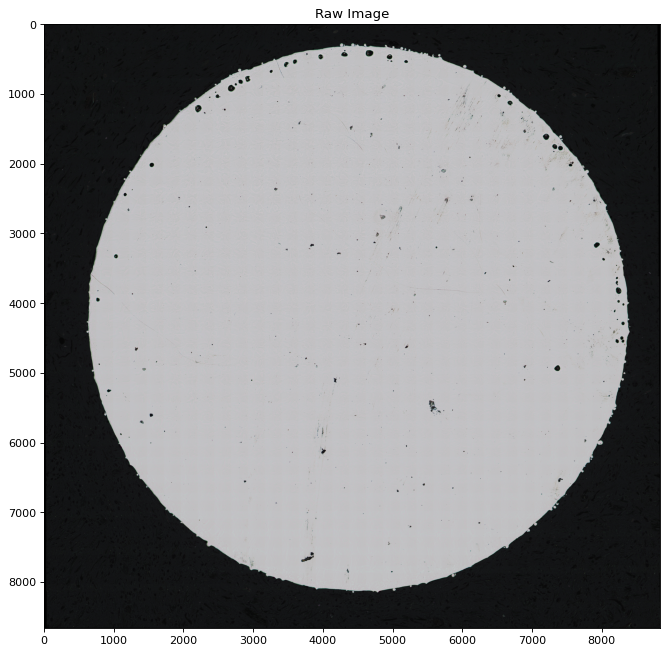

In [4]:
fig, ax = plt.subplots(figsize=(10, 10),dpi=80)
ax.set_title("Raw Image")
#ax.axis("off")
imgAx = ax.imshow(img)

In [5]:
# Binarise Img
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
clone = np.copy(gray)
binImg = cv2.threshold(clone, int(100), 255, cv2.THRESH_BINARY)[1]

In [6]:
np.max(np.max(gray))

254

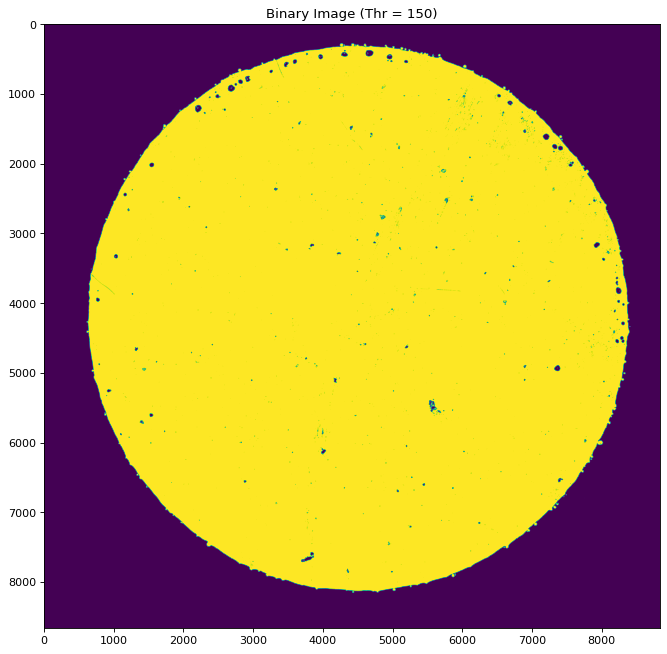

In [7]:
fig, ax = plt.subplots(figsize=(10, 10),dpi=80)
ax.set_title("Binary Image (Thr = 150)")
#ax.axis("off")
imgAx = ax.imshow(binImg)

In [8]:
# Find contours - includes 
contours, hierarchy = cv2.findContours(binImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
if area == 'hatch':
    sectionCont = max(contours, key=lambda x: cv2.contourArea(x))
    sectionIndex = list(map(lambda x: (np.array_equal(x, sectionCont)) & (cv2.contourArea(x) < binImg.size), contours)).index(True)

    clone = np.copy(img)
    mask = np.zeros(img.shape[0:2], np.uint8) # hatch mask
    cv2.drawContours(mask, contours, sectionIndex, (255, 0, 0), thickness=cv2.FILLED) # make hatch mask = section mask
    cont_mask = np.copy(mask)
    
    # reduce hatch mask to only hatching area
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 3)
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    mask = cv2.threshold(dist, 0.1125, 1, cv2.THRESH_BINARY)[1].astype(np.uint8)
    
    cont_mask = (cv2.subtract(cont_mask,mask*255)/255).astype('uint8')
    
elif area == 'section':
    sectionCont = max(contours, key=lambda x: cv2.contourArea(x))
    sectionIndex = list(map(lambda x: (np.array_equal(x, sectionCont)) & (cv2.contourArea(x) < binImg.size), contours)).index(True)

    clone = np.copy(img)
    mask = np.zeros(img.shape[0:2], np.uint8)
    cv2.drawContours(mask, contours, sectionIndex, (1, 1, 1), thickness=cv2.FILLED)
    
elif area == 'whole':
    mask = np.ones(img.shape[0:2])

res = np.multiply(gray,mask)
if area == 'hatch':
    cont_res = np.multiply(gray,cont_mask)

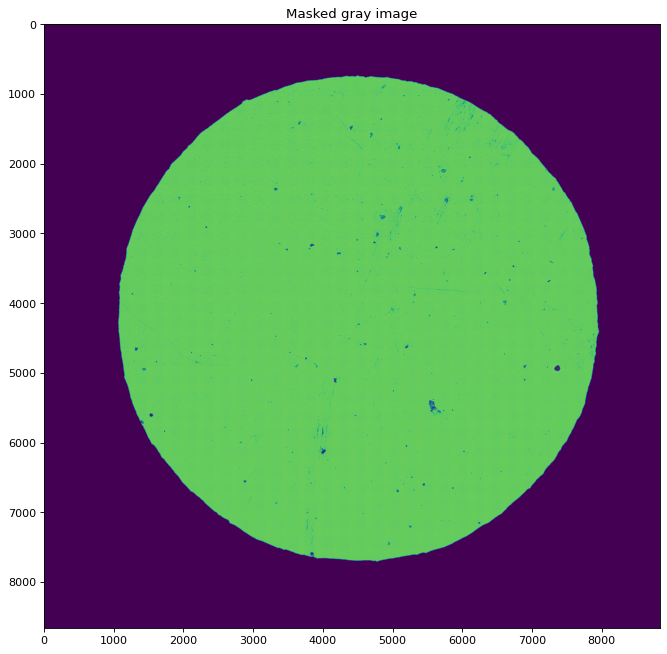

In [9]:
fig, ax = plt.subplots(figsize=(20, 10),dpi=80)
ax.set_title("Masked gray image")
#ax.axis("off")
imgAx = ax.imshow(res)

In [10]:
%%time
# create list on pixels in bulk area
pts = np.where(mask == 1)
lst_intensities = np.zeros_like(pts)
lst_intensities = res[pts[0], pts[1]]

CPU times: user 1.2 s, sys: 730 ms, total: 1.93 s
Wall time: 1.97 s


In [11]:
%%time
# Find optimal threshold:
    # test porosity level for thresholds between 100-255
    # Not lower than 100 because some very porous sample exhibit and intial jump in porosity and  trigger low threshold vals
    # Differetiate porosity/threshold
    # Find when the rate of increases above 0.05 % porosity/threshold val, point at which the non-porosity objects (which are bright) are begining to be included in the evaluated area.
    # We only want the porosity vals, which shoudl all be dark areas.
start = 0
end = 250
    
porosity = np.zeros(end-start)
for thr in range(start,end):
    porosity[thr-start] = len(lst_intensities[lst_intensities>thr])/len(lst_intensities)
diffPorosity = np.diff(1-porosity)
diff2Porosity = np.diff(diffPorosity)



CPU times: user 7.7 s, sys: 836 ms, total: 8.54 s
Wall time: 8.56 s


## Plot porosity vs threshold

In [12]:
thr = 150

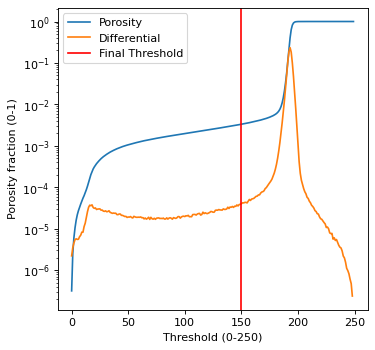

In [13]:
fig, ax = plt.subplots(figsize=(5,5),dpi=80)
ax.plot(list(range(start,end)),1-porosity,label="Porosity")
ax.plot(list(range(start,end-1)),diffPorosity,label="Differential")
#ax.plot(list(range(start,end-2)),diff2Porosity,label="2nd Differential")

#ax.axhline(0.0005,c='k',linestyle='--',label='0.05% Differential')
line = ax.axvline(thr,c='r',label='Final Threshold')

ax.set_ylabel('Porosity fraction (0-1)')
ax.set_xlabel('Threshold ('+str(start)+'-'+str(end)+')')
#ax.set_xlim([20,180])
#ax.set_ylim([0,0.006])
ax.set_yscale('log')
#ax.set_xticks(np.linspace(0,250,11))
ax.legend()

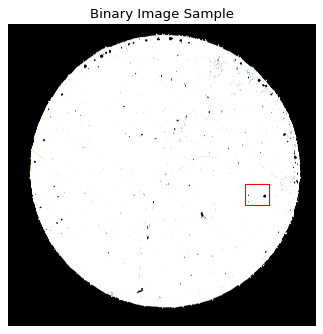

In [14]:
# Binary Image
binImg = cv2.threshold(clone, int(thr), 255, cv2.THRESH_BINARY)[1]

fig, ax = plt.subplots(figsize=(5,5),dpi=80)
ax.set_title("Binary Image Sample")
ax.axis("off")
imgAx = ax.imshow(binImg,cmap='Greys')
# Create a Rectangle patch
rect = matplotlib.patches.Rectangle((6800,4600),700,600,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

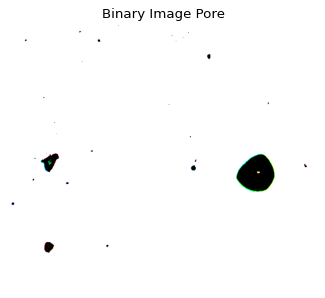

In [15]:
# Zoomed image
fig, ax = plt.subplots(figsize=(5,5),dpi=80)
ax.set_title("Binary Image Pore")
ax.axis("off")
imgAx2 = ax.imshow(binImg[4600:5200,6800:7500],cmap='Greys')

## Plot exponential of porostity and find 'Flat' section

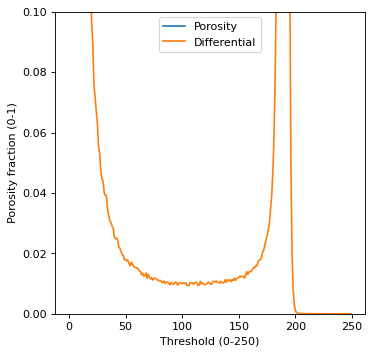

In [16]:
expPorosity = np.log(1-porosity)
expPorosityDiff = np.diff(expPorosity)

fig, ax = plt.subplots(figsize=(5,5),dpi=80)
ax.plot(list(range(start,end)),expPorosity,label="Porosity")
ax.plot(list(range(start,end-1)),expPorosityDiff,label="Differential")

#line = ax.axvline(thr,c='r',label='Final Threshold')

ax.set_ylim([0, 0.1])

ax.set_ylabel('Porosity fraction (0-1)')
ax.set_xlabel('Threshold ('+str(start)+'-'+str(end)+')')

ax.legend()

## Make GIF for thresholding

In [17]:
%%time
thr=0
start = 5
end = 250

# Create list of porosities
porosity = np.zeros(end-start)
for thr in range(start,end):
    porosity[thr-start] = len(lst_intensities[lst_intensities>thr])/len(lst_intensities)
diffPorosity = np.diff(1-porosity)
diff2Porosity = np.diff(diffPorosity)

fig, ax = plt.subplots(1,3,figsize=(15,5),dpi=80)
title = fig.suptitle('Threshold='+str(0)+', Porosity='+str(0))

# Graph set up and plotting
ax[0].plot(list(range(start,end)),1-porosity,label="Porosity")
ax[0].plot(list(range(start,end-1)),diffPorosity,label="Differential")
ax[0].set_ylabel('Porosity fraction (0-1)')
ax[0].set_xlabel('Threshold ('+str(start)+'-'+str(end)+')')
#ax.plot(list(range(start,end-2)),diff2Porosity,label="2nd Differential")
ax[0].set_yscale('log')
ax[0].legend()
#ax.axhline(0.0005,c='k',linestyle='--',label='0.05% Differential')
line = ax[0].axvline(thr,c='r',label='Final Threshold')

# Binary Image set up
binImg = cv2.threshold(clone, int(thr), 255, cv2.THRESH_BINARY)[1]
#fig, ax = plt.subplots(figsize=(20, 10),dpi=80)
ax[1].set_title("Binary Image Sample")
#ax.axis("off")
imgAx = ax[1].imshow(binImg,cmap='Greys')
rect = matplotlib.patches.Rectangle((6800,4600),700,600,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax[1].add_patch(rect)

# Zoomed Binary image of pore
#fig, ax = plt.subplots(figsize=(20, 10),dpi=80)
ax[2].set_title("Binary Image Pore")
#ax.axis("off")
imgAx2 = ax[2].imshow(binImg[4600:5200,6800:7500],cmap='Greys')


def init():
    line.set_xdata([])
    return line,
def animate(i,clone,porosity):
    thr = i+start
    pval = (1-porosity[i])*100
    
    title.set_text('Threshold='+str(thr)+', Porosity='+str(round(pval, 2))+'%')
    
    line.set_xdata([thr])
    binImg = cv2.threshold(clone, int(thr), 255, cv2.THRESH_BINARY)[1]
    imgAx.set_data(binImg)
    imgAx2.set_data(binImg[4600:5200,6800:7500])

    return line,imgAx,imgAx2,

anim = FuncAnimation(fig, animate, init_func=init,fargs=[clone,porosity],frames=(end-start), interval=100, blit=True)

writer = PillowWriter()  
#anim.save('sine_wave.gif',writer=writer)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11d4504c0> (for post_execute):


KeyboardInterrupt: 

In [18]:
fig, ax = plt.subplots(figsize=(5,5),dpi=80)
ax.plot(list(range(start,end)),1-porosity,label="Porosity")
ax.plot(list(range(start,end-1)),diffPorosity,label="Differential")
#ax.plot(list(range(start,end-2)),diff2Porosity,label="2nd Differential")

#ax.axhline(0.0005,c='k',linestyle='--',label='0.05% Differential')
line = ax.axvline(thr,c='r',label='Final Threshold')

ax.set_ylabel('Porosity fraction (0-1)')
ax.set_xlabel('Threshold ('+str(start)+'-'+str(end)+')')
#ax.set_xlim([20,180])
#ax.set_ylim([0,0.006])
ax.set_yscale('log')
#ax.set_xticks(np.linspace(0,250,11))
ax.legend()

Error in callback <function flush_figures at 0x11d4504c0> (for post_execute):


KeyboardInterrupt: 